## package install/import

In [32]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/GraLSP_pytorch-master')

Mounted at /content/drive/


In [21]:
!pip install torch torchvision torch-geometric networkx


In [44]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

## Original GCN for Cora Node Classification

Processing...
Done!


Epoch: 020, Loss: 0.5017, Accuracy: 0.7930, F1 Score: 0.7930
Epoch: 040, Loss: 0.3203, Accuracy: 0.7947, F1 Score: 0.7947
Epoch: 060, Loss: 0.2573, Accuracy: 0.7972, F1 Score: 0.7972
Epoch: 080, Loss: 0.2531, Accuracy: 0.7988, F1 Score: 0.7988
Epoch: 100, Loss: 0.2259, Accuracy: 0.7972, F1 Score: 0.7972
Epoch: 120, Loss: 0.2019, Accuracy: 0.7939, F1 Score: 0.7939
Epoch: 140, Loss: 0.1808, Accuracy: 0.7955, F1 Score: 0.7955
Epoch: 160, Loss: 0.1981, Accuracy: 0.7939, F1 Score: 0.7939
Epoch: 180, Loss: 0.1829, Accuracy: 0.7939, F1 Score: 0.7939
Epoch: 200, Loss: 0.1794, Accuracy: 0.7955, F1 Score: 0.7955
Epoch: 220, Loss: 0.1799, Accuracy: 0.7922, F1 Score: 0.7922
Epoch: 240, Loss: 0.1741, Accuracy: 0.7914, F1 Score: 0.7914
Epoch: 260, Loss: 0.1609, Accuracy: 0.7922, F1 Score: 0.7922
Epoch: 280, Loss: 0.1695, Accuracy: 0.7914, F1 Score: 0.7914
Epoch: 300, Loss: 0.1608, Accuracy: 0.7922, F1 Score: 0.7922
Epoch: 320, Loss: 0.1484, Accuracy: 0.7914, F1 Score: 0.7914
Epoch: 340, Loss: 0.1538

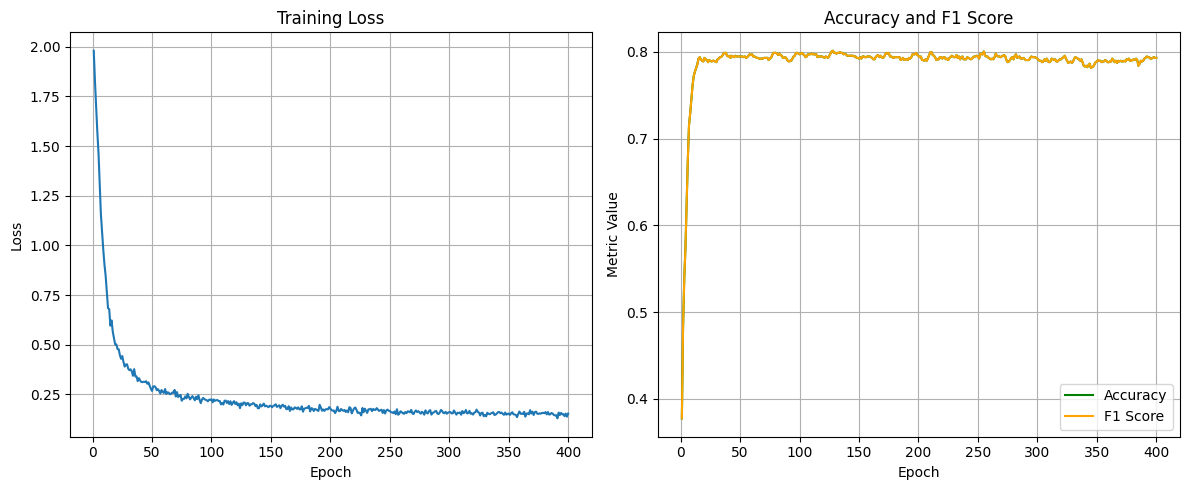

In [34]:
import  torch
import  torch.nn.functional     as F
from    torch_geometric.nn      import GCNConv
import  numpy                   as np
import  pandas                  as pd
from    sklearn.preprocessing   import  LabelEncoder
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data


# Load data
cora_df         = pd.read_csv(r'cora/cora.content', header=None, sep='\t')
cora_cites      = pd.read_csv(r'cora/cora.cites', header=None, sep='\t')

cora_df
labels          = cora_df.iloc[:, -1].values
le              = LabelEncoder()
labels_y        = le.fit_transform(labels)
edge_index      = torch.tensor(cora_cites.values.T, dtype=torch.long)

node_ids        = cora_df.iloc[:, 0].values
id_map          = {node_id: i for i, node_id in enumerate(node_ids)}
cora_df[0].replace(id_map, inplace=True)
cora_cites[0]   = cora_cites[0].map(id_map)
cora_cites[1]   = cora_cites[1].map(id_map)

node_features   = torch.randn(10, 5)
edge_index      = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]])
labels          = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
train_mask      = torch.tensor([True, True, False, False, True, True, False, False, False, False])
test_mask       = torch.tensor([False, False, False, False, False, False, False, False, True, True])
data1           = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)
node_features2  = torch.tensor(np.array(cora_df.iloc[:, 1:-1]), dtype=torch.float)
edge_index2     = torch.tensor(cora_cites.values.T, dtype=torch.int64)
labels2         = torch.tensor(labels_y, dtype=torch.int64)
train_mask2     = torch.tensor([True]*1500 + [False]*1208)
test_mask2      = torch.tensor([False]*1500 + [True]*1208)
data2           = Data(x=node_features2, edge_index=edge_index2, y=labels2, train_mask=train_mask2, test_mask=test_mask2)



# we use data2 to test....

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

# Load Cora dataset
dataset = Planetoid(root='/tmp/cora', name='Cora')
data_we_want    = dataset[0]
data_we_want.x              # this is very important
data_we_want.edge_index     # and we should focus on
data_we_want.y              # these data form
data_we_want.train_mask     # and if you are sensitive
data_we_want.val_mask       # you will find it's all
data_we_want.test_mask      # built by tensor

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data_t = data2.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_t.x, data_t.edge_index)
    loss = F.nll_loss(out[data_t.train_mask], data_t.y[data_t.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data_t.x, data_t.edge_index)
    pred = out.argmax(dim=1)
    acc = (pred[data_t.test_mask] == data_t.y[data_t.test_mask]).sum().item() / data_t.test_mask.sum().item()
    f1 = f1_score(data_t.y[data_t.test_mask].cpu(), pred[data_t.test_mask].cpu(), average='micro')

    return acc, f1

total_acc, total_f1 = 0, 0
epochs = 400
loss_values, acc_values, f1_values = [], [], []

for epoch in range(1, epochs + 1):
    loss = train()
    acc, f1 = test()
    total_acc += acc
    total_f1 += f1
    loss_values.append(loss)
    acc_values.append(acc)
    f1_values.append(f1)
    if epoch %20==0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}')

average_acc = total_acc / epochs
average_f1 = total_f1 / epochs
print(f'Average Accuracy: {average_acc:.4f}, Average F1 Score: {average_f1:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), acc_values, label='Accuracy', color='green')
plt.plot(range(1, epochs + 1), f1_values, label='F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Accuracy and F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for 7 clusters is: 0.4612160921096802


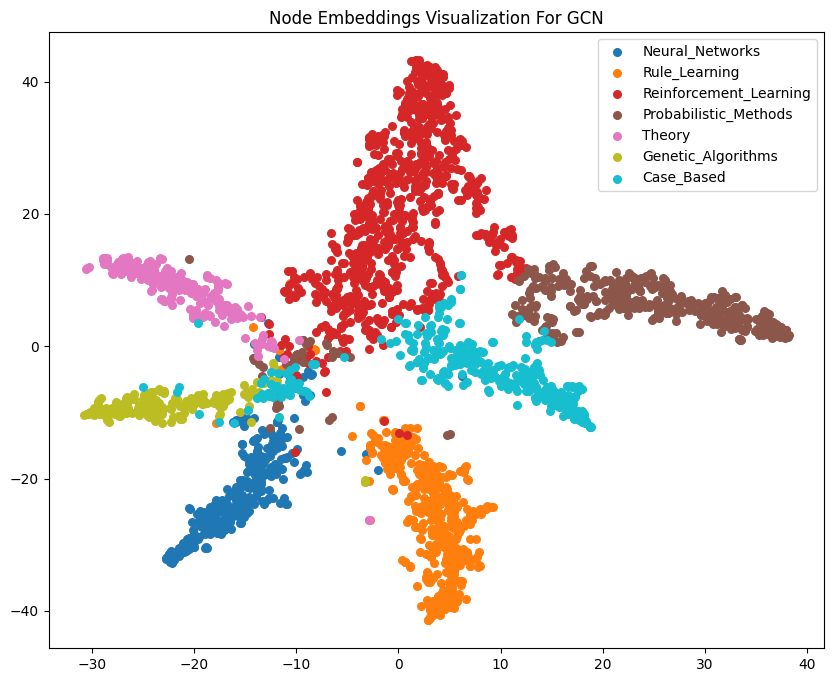

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

with torch.no_grad():
    node_embeddings = model(data_t.x, data_t.edge_index)
    predicted_labels = node_embeddings.argmax(dim=1).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=60, n_iter=600)
embeddings_2d = tsne.fit_transform(node_embeddings.cpu().numpy())


label_mapping = {
    0: 'Neural_Networks',
    1: 'Rule_Learning',
    2: 'Reinforcement_Learning',
    3: 'Probabilistic_Methods',
    4: 'Theory',
    5: 'Genetic_Algorithms',
    6: 'Case_Based'
}

n_clusters = len(label_mapping)
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings_2d)

silhouette_avg = silhouette_score(embeddings_2d, clusters)
print(f"The average silhouette score for {n_clusters} clusters is: {silhouette_avg}")

num_labels = len(label_mapping)
color_map = plt.get_cmap('tab10', num_labels)
plt.figure(figsize=(10, 8))

for label_idx in range(num_labels):
    label_mask = predicted_labels == label_idx
    label_embeddings = embeddings_2d[label_mask]

    label_color = color_map(label_idx / num_labels)

    plt.scatter(
        label_embeddings[:, 0],
        label_embeddings[:, 1],
        c=[label_color],
        label=label_mapping[label_idx],
        s=30,
    )

plt.title('Node Embeddings Visualization For GCN')
plt.legend()
plt.show()


## Random Walk Helper Functions

In [38]:
import torch
import networkx as nx
import numpy as np
# from parser import parameter_parser
import random
import copy
from tqdm import tqdm

class Config:
    def __init__(self):
        self.dataset_name = "cora"
        self.path_length = 10
        self.num_paths = 100
        self.window_size = 6
        self.batch_size = 100
        self.neg_size = 8
        self.learning_rate = 0.002
        self.embedding_dims = 32
        self.epochs = 1
        self.num_skips = 5
        self.num_neighbor = 20
        self.hidden_dim = 100
        self.walk_dim = 30
        self.anonym_walk_len = 8
        self.walk_loss_lambda = 0.1
        self.linkpred_ratio = 0.1
        self.p = 0.25
        self.q = 1
        self.inductive = 0
        self.inductive_model_epoch = None
        self.inductive_model_name = None
        self.save_path = "embeddings/GraLSP"

# Create an instance of the Config class
parser = Config()

def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device

def get_edge_list(parser):
    edge_list = []
    print(parser.dataset_name)
    with open("data/" + parser.dataset_name + "/edges", 'r') as f:
        for line in f:
            elems = line.rstrip().split(' ')
            src, dst = int(elems[0]), int(elems[1])
            if src == dst:
                continue
            edge_list.append((src, dst))
    num_nodes = 1 + max(max([u[0] for u in edge_list]), max([u[1] for u in edge_list]))
    return edge_list, num_nodes

def edge_list2nx(edge_list, num_nodes):
    g = nx.Graph()

    for i in range(num_nodes):
        g.add_node(i)
    for i, j in edge_list:
        g.add_edge(i, j)
    return g

def to_anonym_walk(walk):
        num_app = 0
        apped = dict()
        anonym = []
        for node in walk:
            if node not in apped:
                num_app += 1
                apped[node] = num_app
            anonym.append(apped[node])

        return anonym

def generate_node_walks_and_radius(num_nodes, node_walks):
    node_anonymous_walks = [[] for i in range(num_nodes)]
    node_walk_radius = [[] for i in range(num_nodes)]
    for ws in range(num_nodes):
        for w in node_walks[ws]:  #
            node_anonymous_walks[ws].append(to_anonym_walk(w))
            node_walk_radius[ws].append(int(2*parser.anonym_walk_len/len(np.unique(w[:10]))))
            # node_walk_radius[ws].append(int(2*parser.anonym_walk_len*parser.q/parser.p))
    return node_anonymous_walks, node_walk_radius


def preprocess_transition_prob(g, num_nodes):
    degree_seq_dict = dict(g.degree)
    degree_seq = [degree_seq_dict[i] for i in range(num_nodes)]
    alias_nodes = {}

    for node in g.nodes():
        normalized_probs = [1/degree_seq[node] for i in range(degree_seq[node])]
        alias_nodes[node] = alias_setup(normalized_probs)

    alias_edges = {}

    for edge in g.edges():
        alias_edges[edge] = get_alias_edge(g,edge[0], edge[1])
        alias_edges[(edge[1], edge[0])] = get_alias_edge(g, edge[1], edge[0])

    alias_nodes = alias_nodes
    alias_edges = alias_edges

    return alias_nodes, alias_edges


def get_alias_edge(g,src, dst):
    unnormalized_probs = []
    for dst_nbr in sorted(g.neighbors(dst)):
        if dst_nbr == src:
            unnormalized_probs.append(1/parser.p)
        elif g.has_edge(dst_nbr, src):
            unnormalized_probs.append(1)
        else:
            unnormalized_probs.append(1/parser.q)
    normalize_const = np.sum(unnormalized_probs)
    normalized_probs = [prob/normalize_const for prob in unnormalized_probs]

    return alias_setup(normalized_probs)


def generate_node2vec_walks(g, num_nodes,alias_nodes, alias_edges):
    random_walks = []
    nodes = list(range(num_nodes))
    for _ in tqdm(range(parser.num_paths)):
        random.shuffle(nodes)
        for node in nodes:
            walk = node2vec_walk(g, node,alias_nodes, alias_edges)
            random_walks.append(walk)

    node_walks = [[] for i in range(num_nodes)]

    for w in random_walks:
        node_walks[w[0]].append(w)
    return node_walks, random_walks


def node2vec_walk(g, begin_node,alias_nodes, alias_edges):
    walk = [begin_node]

    while(len(walk) < parser.path_length):
        cur = walk[-1]
        cur_neighbors = get_neighbor(g, cur)
        cur_neighbors = sorted(cur_neighbors)
        if len(cur_neighbors):
            if len(walk) == 1:

                abc = alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])

                walk.append(cur_neighbors[abc])
            else:
                prev = walk[-2]
                nextnode = cur_neighbors[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(nextnode)
        else:
            break

    return walk


def get_neighbor(g, node):
    neighbor = [n for n in g.neighbors(node)]
    return neighbor

def alias_setup(probs):
    """
    https://www.cnblogs.com/shenxiaolin/p/9097478.html
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K).astype(int)
    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) >0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()
        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    K = len(J)
    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand()<q[kk]:
        return kk
    else:
        return J[kk]


def generate_anonym_walks(length):

    anonymous_walks = []
    def generate_anonymous_walk(totlen, pre):
        if len(pre) == totlen:
            anonymous_walks.append(pre)
            return
        else:
            candidate = max(pre) + 1 # 2
            for i in range(1, candidate+1): # 1,2
                if i!= pre[-1]:
                    npre = copy.deepcopy(pre)
                    npre.append(i)  # 1,2
                    generate_anonymous_walk(totlen, npre) # [1,2], [1,2,1],[1,2,3],[1,2,3,1],[1,2,3,2],.....
    generate_anonymous_walk(length, [1])
    return anonymous_walks


def generate_walk2num_dict(length):
    anonym_walks = generate_anonym_walks(length)
    anonym_dict = dict()
    curid = 0
    for walk in anonym_walks:
        swalk = intlist_to_str(walk)
        anonym_dict[swalk] = curid
        curid += 1
    return anonym_dict

def intlist_to_str(lst):
    slst = [str(x) for x in lst]
    strlst = "".join(slst)
    return strlst


def process_anonym_distr(num_nodes, length, node_anonymous_walks):
    node_anonym_walktypes = np.zeros((num_nodes, parser.num_paths))
    anonym_walk_dict = generate_walk2num_dict(length)
    node_anonym_distr = np.zeros((num_nodes, len(anonym_walk_dict)))
    for n in range(num_nodes):
        for idxw in range(len(node_anonymous_walks[n])):
            w = node_anonymous_walks[n][idxw]
            strw = intlist_to_str(w[:length])
            wtype = anonym_walk_dict[strw]
            node_anonym_walktypes[n][idxw] = wtype
            node_anonym_distr[n][wtype] += 1
    node_anonym_distr /= parser.num_paths
    graph_anonym_distr = np.mean(node_anonym_distr, axis = 0)
    graph_anonym_std = np.std(node_anonym_distr, axis = 0)
    graph_anonym_std[np.where(graph_anonym_std == 0)] = 0.001

    return (node_anonym_distr - graph_anonym_distr)/graph_anonym_std, node_anonym_walktypes



def generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius):
    types_and_nodes = [[] for i in range(num_nodes)]
    for ws in range(num_nodes):
        for _ in range(parser.num_paths * parser.num_skips):
            wk = random.randint(0, parser.num_paths-1)

            types_and_nodes[ws].append([node_anonym_walktypes[ws][wk].astype(int), random.choice(node_walks[ws][wk][:node_walk_radius[ws][wk]])])
    types_and_nodes = np.array(types_and_nodes).astype(int)
    return types_and_nodes


def get_node2label(num_nodes):
    node2label = np.zeros((num_nodes))
    with open("data/" + parser.dataset_name + "/node2label") as infile:
        for line in infile:
            elems = line.rstrip().split(" ")
            node, label = int(elems[0]), int(elems[1])
            node2label[node] = label
    node2label = node2label.astype(int)
    return node2label

In [10]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)
alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)

print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)
node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)
node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)
types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)
types_and_nodes = torch.tensor(types_and_nodes,device = device)

Reading dataset
cora
Generating nx graphs...


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


In [12]:
len(node2label), parser.feature_dims, node2label

(2708, 300, array([0, 1, 2, ..., 5, 6, 0]))

In [25]:
len(random_walks), len(random_walks[0]), len(node_walks), len(node_walks[0]), len(node_walks[0][0])
# each node has 100 random walk, each walk is 10 hops long, so the random walk is a matrix that is (270800, 10)
# for node_walk, it is 2708*100*10 dimension, indicating each node has 100 random walk, each walk is 10 length long,

(270800, 10, 2708, 100, 10)

In [26]:
node_features.shape, parser.feature_dims
# each node has 300 features dimension [2708, 300]

(torch.Size([2708, 300]), 300)

In [39]:
import random

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)
alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)

def aggregate_walks(node_walks, num_nodes):
    # Initialize an array to store aggregated walk data
    aggregated_walks = np.zeros((num_nodes, num_nodes))

    for node_idx, walks in enumerate(node_walks):
        # Aggregate walks for each node
        for walk in walks:
            aggregated_walks[node_idx] += np.bincount(walk, minlength=num_nodes)

        # Average the counts
        aggregated_walks[node_idx] /= len(walks)

    return torch.tensor(aggregated_walks, dtype=torch.float32)

def add_statistical_features(node_features):
    mean_features = torch.mean(node_features, dim=1, keepdim=True)
    std_features = torch.std(node_features, dim=1, keepdim=True)
    max_features = torch.max(node_features, dim=1)[0].unsqueeze(1)
    # Add other statistical features as needed

    enhanced_features = torch.cat([node_features, mean_features, std_features, max_features], dim=1)
    return enhanced_features


    enhanced_features = torch.cat([node_features, mean_features, std_features, max_features], dim=1)
    return enhanced_features

from sklearn.decomposition import PCA

def reduce_dimensions_pca(features, n_components=64):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return torch.tensor(reduced_features, dtype=torch.float32)



from sklearn.manifold import TSNE

def reduce_dimensions_tsne(features, n_components=2, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
    reduced_features = tsne.fit_transform(features)
    return torch.tensor(reduced_features, dtype=torch.float32)

aggregated_walk_features = aggregate_walks(node_walks, num_nodes=2708).to(device)
reduced_walk_features = reduce_dimensions_pca(aggregated_walk_features.cpu().numpy()).to(device)
enhanced_node_features = add_statistical_features(node_features).to(device)
combined_features = torch.cat([enhanced_node_features, reduced_walk_features], dim=1).float()

Reading dataset
cora
Generating nx graphs...


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


In [33]:
combined_features.shape, combined_features.shape[1]
# original feature 300 + 2708 aggregate random walk feature, using counting strategy

(torch.Size([2708, 367]), 367)

## Train/Test GCN with Random Walk as additional node feature (Counting)

Epoch: 020, Loss: 0.4454, Accuracy: 0.7765, F1 Score: 0.7765
Epoch: 040, Loss: 0.2712, Accuracy: 0.7674, F1 Score: 0.7674
Epoch: 060, Loss: 0.2325, Accuracy: 0.7616, F1 Score: 0.7616
Epoch: 080, Loss: 0.1925, Accuracy: 0.7558, F1 Score: 0.7558
Epoch: 100, Loss: 0.1690, Accuracy: 0.7591, F1 Score: 0.7591
Epoch: 120, Loss: 0.1562, Accuracy: 0.7649, F1 Score: 0.7649
Epoch: 140, Loss: 0.1516, Accuracy: 0.7616, F1 Score: 0.7616
Epoch: 160, Loss: 0.1316, Accuracy: 0.7624, F1 Score: 0.7624
Epoch: 180, Loss: 0.1382, Accuracy: 0.7674, F1 Score: 0.7674
Epoch: 200, Loss: 0.1299, Accuracy: 0.7575, F1 Score: 0.7575
Epoch: 220, Loss: 0.1250, Accuracy: 0.7616, F1 Score: 0.7616
Epoch: 240, Loss: 0.1311, Accuracy: 0.7649, F1 Score: 0.7649
Epoch: 260, Loss: 0.1166, Accuracy: 0.7608, F1 Score: 0.7608
Epoch: 280, Loss: 0.1281, Accuracy: 0.7608, F1 Score: 0.7608
Epoch: 300, Loss: 0.1111, Accuracy: 0.7541, F1 Score: 0.7541
Epoch: 320, Loss: 0.1135, Accuracy: 0.7591, F1 Score: 0.7591
Epoch: 340, Loss: 0.1106

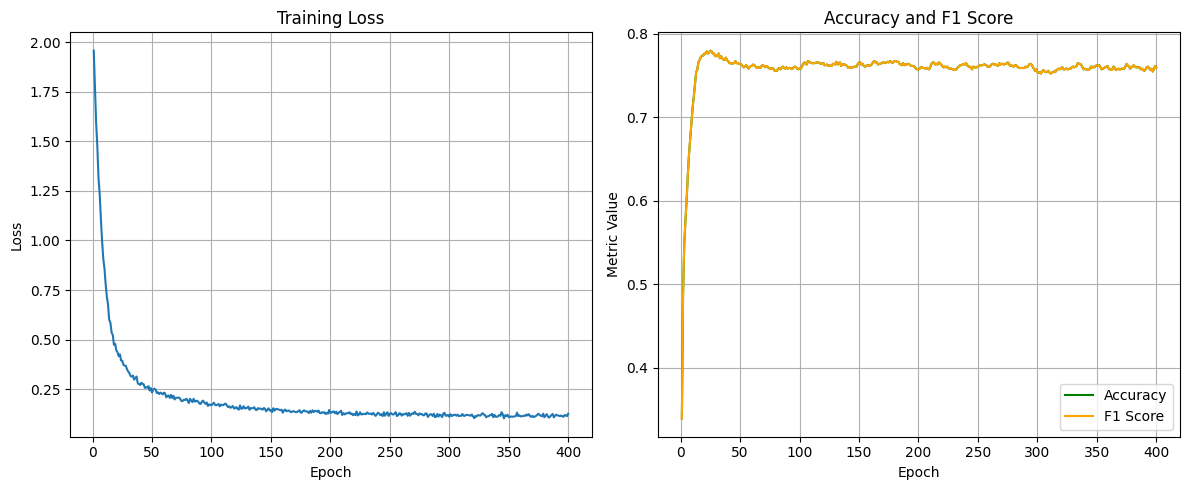

In [40]:
import random
# Train the GNN with the new feature with random walk
class ModifiedGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(ModifiedGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

num_features = 3008  # Combined feature size
hidden_channels = 16  # can be tuned
num_classes = 7

model = ModifiedGCN(num_features=combined_features.shape[1], hidden_channels=32, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# Ensure edge_index is a LongTensor
data_t.edge_index = data_t.edge_index.long()

# In your train and test functions, make sure combined_features is a FloatTensor
def train():
    model.train()
    optimizer.zero_grad()
    out = model(combined_features.float(), data_t.edge_index)  # Ensure float type
    target = data_t.y[data_t.train_mask].long()
    loss = F.nll_loss(out[data_t.train_mask], target)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(combined_features.float(), data_t.edge_index)  # Ensure float type
    pred = out.argmax(dim=1)
    target = data_t.y[data_t.test_mask].long()
    acc = (pred[data_t.test_mask] == target).sum().item() / data_t.test_mask.sum().item()
    f1 = f1_score(target.cpu(), pred[data_t.test_mask].cpu(), average='micro')
    return acc, f1




from sklearn.metrics import f1_score
# Variables to store metrics
import matplotlib.pyplot as plt
total_acc, total_f1 = 0, 0
epochs = 400
loss_values, acc_values, f1_values = [], [], []

for epoch in range(1, epochs + 1):
    loss = train()
    acc, f1 = test()
    total_acc += acc
    total_f1 += f1
    loss_values.append(loss)
    acc_values.append(acc)
    f1_values.append(f1)
    if epoch %20==0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}')

# Calculate and print average accuracy and F1 score
average_acc = total_acc / epochs
average_f1 = total_f1 / epochs
print(f'Average Accuracy: {average_acc:.4f}, Average F1 Score: {average_f1:.4f}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), acc_values, label='Accuracy', color='green')
plt.plot(range(1, epochs + 1), f1_values, label='F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Accuracy and F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for 7 clusters is: 0.46771717071533203


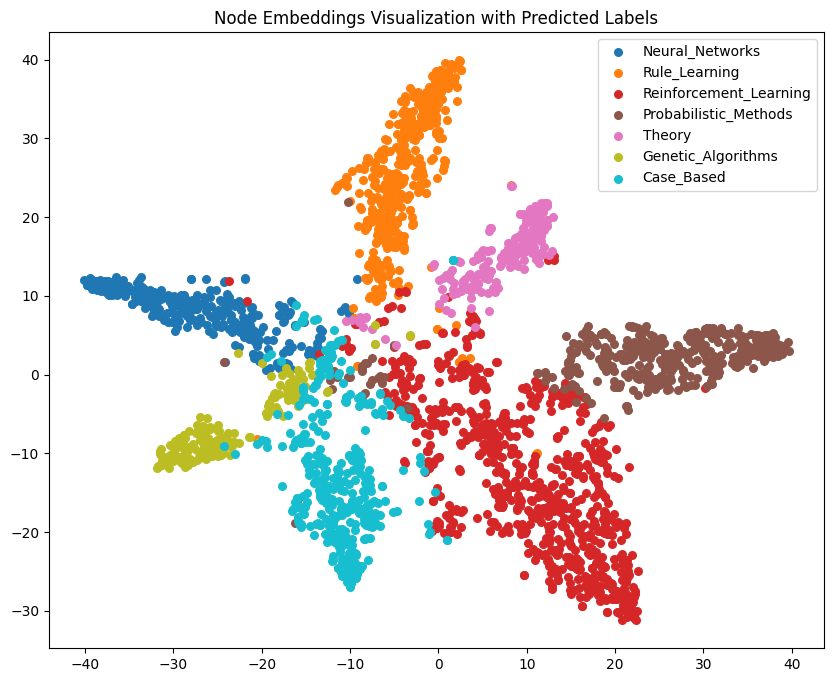

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

with torch.no_grad():
    node_embeddings = model(combined_features, data_t.edge_index)
    predicted_labels = node_embeddings.argmax(dim=1).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=60, n_iter=600)
embeddings_2d = tsne.fit_transform(node_embeddings.cpu().numpy())

label_mapping = {
    0: 'Neural_Networks',
    1: 'Rule_Learning',
    2: 'Reinforcement_Learning',
    3: 'Probabilistic_Methods',
    4: 'Theory',
    5: 'Genetic_Algorithms',
    6: 'Case_Based'
}

n_clusters = len(label_mapping)
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings_2d)
silhouette_avg = silhouette_score(embeddings_2d, clusters)
print(f"The average silhouette score for {n_clusters} clusters is: {silhouette_avg}")


num_labels = len(label_mapping)
color_map = plt.get_cmap('tab10', num_labels)
plt.figure(figsize=(10, 8))

for label_idx in range(num_labels):
    label_mask = predicted_labels == label_idx
    label_embeddings = embeddings_2d[label_mask]
    label_color = color_map(label_idx / num_labels)

    plt.scatter(
        label_embeddings[:, 0],
        label_embeddings[:, 1],
        c=[label_color],
        label=label_mapping[label_idx],
        s=30,
    )

plt.title('Node Embeddings Visualization with Predicted Labels')
plt.legend()
plt.show()


## Train/Test GCN with Random Walk as additional node feature (Word2Vec)

In [45]:
from gensim.models import Word2Vec

def train_word2vec(walks, vector_size=64, window=5, workers=4, sg=1):
    walks_str = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(sentences=walks_str, vector_size=vector_size, window=window, workers=workers, sg=sg)
    return model

flat_walks = [node for walk in node_walks for node in walk]
word2vec_model = train_word2vec(flat_walks)

def create_node_embeddings(model, num_nodes, vector_size):
    embeddings = np.zeros((num_nodes, vector_size))
    for i in range(num_nodes):
        node_str = str(i)
        if node_str in model.wv:
            embeddings[i] = model.wv[node_str]
        else:
            pass
    return torch.tensor(embeddings, dtype=torch.float32)

node_embeddings = create_node_embeddings(word2vec_model, num_nodes=2708, vector_size=64).to(device)
print("Shape of node_features:", node_features.shape)
print("Shape of node_embeddings:", node_embeddings.shape)
combined_features = torch.cat([node_features, node_embeddings], dim=1)

Shape of node_features: torch.Size([2708, 300])
Shape of node_embeddings: torch.Size([2708, 64])


Epoch: 020, Loss: 0.4802, Accuracy: 0.7500, F1 Score: 0.7500
Epoch: 040, Loss: 0.3245, Accuracy: 0.7599, F1 Score: 0.7599
Epoch: 060, Loss: 0.2588, Accuracy: 0.7624, F1 Score: 0.7624
Epoch: 080, Loss: 0.2082, Accuracy: 0.7608, F1 Score: 0.7608
Epoch: 100, Loss: 0.1959, Accuracy: 0.7624, F1 Score: 0.7624
Epoch: 120, Loss: 0.1754, Accuracy: 0.7632, F1 Score: 0.7632
Epoch: 140, Loss: 0.1639, Accuracy: 0.7682, F1 Score: 0.7682
Epoch: 160, Loss: 0.1572, Accuracy: 0.7666, F1 Score: 0.7666
Epoch: 180, Loss: 0.1450, Accuracy: 0.7748, F1 Score: 0.7748
Epoch: 200, Loss: 0.1399, Accuracy: 0.7724, F1 Score: 0.7724
Epoch: 220, Loss: 0.1345, Accuracy: 0.7724, F1 Score: 0.7724
Epoch: 240, Loss: 0.1210, Accuracy: 0.7740, F1 Score: 0.7740
Epoch: 260, Loss: 0.1274, Accuracy: 0.7715, F1 Score: 0.7715
Epoch: 280, Loss: 0.1287, Accuracy: 0.7690, F1 Score: 0.7690
Epoch: 300, Loss: 0.1305, Accuracy: 0.7757, F1 Score: 0.7757
Epoch: 320, Loss: 0.1153, Accuracy: 0.7732, F1 Score: 0.7732
Epoch: 340, Loss: 0.1221

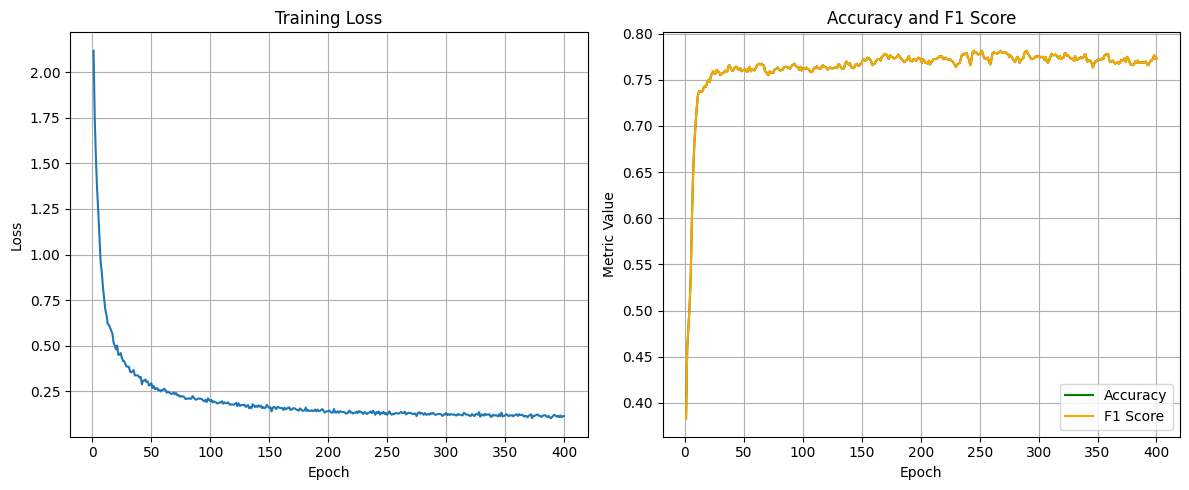

In [46]:
import random
# Train the GNN with the new feature with random walk
class ModifiedGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(ModifiedGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

num_features = 3008
hidden_channels = 16
num_classes = 7

model = ModifiedGCN(num_features=combined_features.shape[1], hidden_channels=32, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data_t.edge_index = data_t.edge_index.long()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(combined_features.float(), data_t.edge_index)
    target = data_t.y[data_t.train_mask].long()
    loss = F.nll_loss(out[data_t.train_mask], target)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(combined_features.float(), data_t.edge_index)
    pred = out.argmax(dim=1)
    target = data_t.y[data_t.test_mask].long()
    acc = (pred[data_t.test_mask] == target).sum().item() / data_t.test_mask.sum().item()
    f1 = f1_score(target.cpu(), pred[data_t.test_mask].cpu(), average='micro')
    return acc, f1


total_acc, total_f1 = 0, 0
epochs = 400
loss_values, acc_values, f1_values = [], [], []

for epoch in range(1, epochs + 1):
    loss = train()
    acc, f1 = test()
    total_acc += acc
    total_f1 += f1
    loss_values.append(loss)
    acc_values.append(acc)
    f1_values.append(f1)
    if epoch %20==0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}')

average_acc = total_acc / epochs
average_f1 = total_f1 / epochs
print(f'Average Accuracy: {average_acc:.4f}, Average F1 Score: {average_f1:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), acc_values, label='Accuracy', color='green')
plt.plot(range(1, epochs + 1), f1_values, label='F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Accuracy and F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for 7 clusters is: 0.46463698148727417


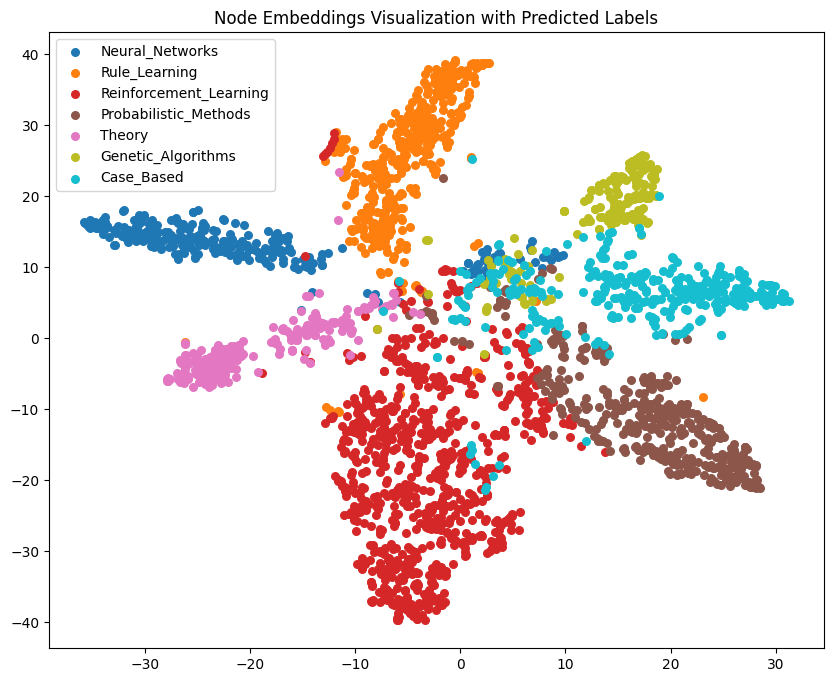

In [48]:
with torch.no_grad():
    node_embeddings = model(combined_features.float(), data_t.edge_index)
    predicted_labels = node_embeddings.argmax(dim=1).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=60, n_iter=600)
embeddings_2d = tsne.fit_transform(node_embeddings.cpu().numpy())

label_mapping = {
    0: 'Neural_Networks',
    1: 'Rule_Learning',
    2: 'Reinforcement_Learning',
    3: 'Probabilistic_Methods',
    4: 'Theory',
    5: 'Genetic_Algorithms',
    6: 'Case_Based'
}

n_clusters = len(label_mapping)
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(embeddings_2d)
silhouette_avg = silhouette_score(embeddings_2d, clusters)
print(f"The average silhouette score for {n_clusters} clusters is: {silhouette_avg}")


num_labels = len(label_mapping)
color_map = plt.get_cmap('tab10', num_labels)
plt.figure(figsize=(10, 8))

for label_idx in range(num_labels):
    label_mask = predicted_labels == label_idx
    label_embeddings = embeddings_2d[label_mask]
    label_color = color_map(label_idx / num_labels)

    plt.scatter(
        label_embeddings[:, 0],
        label_embeddings[:, 1],
        c=[label_color],
        label=label_mapping[label_idx],
        s=30,
    )

plt.title('Node Embeddings Visualization with Predicted Labels')
plt.legend()
plt.show()


## Random Walk embedding Visiualization

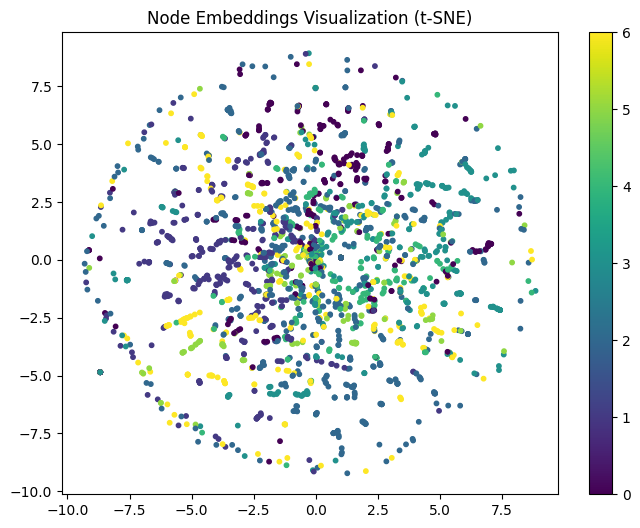

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(walk_features.cpu().numpy())

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=data_t.y.cpu(), cmap='viridis', s=10)
plt.title('Random Walk Embedding for each Nodes')
plt.colorbar()
plt.show()
